# Let's explore the RFX MDSplus tree

## Importing and setting up stuff

In [1]:
import MDSplus as mds
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time, random
from tqdm import tqdm
import h5py as h5
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')
np.set_printoptions(precision=3, suppress=True)

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
MDSplus version: 1.0.0


In [2]:
#color the terminal output
def pick_random_color():
    return '\033[38;5;{}m'.format(random.randint(8, 230))
ENDC = '\033[0m'
ERR = '\033[91m'+ 'ERR: '
OK = '\033[92m' 
WARN = '\033[93m'+ 'WARN: '

In [3]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only
from convert_to_hdf5 import SEG_FAULT_NODES

## Traversing the tree

In [4]:
# traverse the tree, use MAX_DEPTH to limit the depth of the tree to traverse
# othwerwise the script will run for about 10 minutes
MAX_DEPTH = 3# 13 # maximum depth of the tree to traverse
COLORS = [pick_random_color() for _ in range(MAX_DEPTH)]

In [5]:
usage_depth, usage_breadth = {},{}
total_nodes_depth, total_nodes_breadth = [],[]

def traverse_tree_depth_first(max_depth, node, level=0, path='', node_type='child'):
    try: 
        if level >= max_depth: return # stop if the maximum depth is reached
        if node.getFullPath() in SEG_FAULT_NODES: return # skip the nodes that cause segfault
        if node_type == 'child': node_name = node.node_name.upper()
        elif node_type == 'member': node_name = node.node_name.lower()
        else: raise
        path = path + '/' + COLORS[level] + node_name + ENDC # add the node name
        total_nodes_depth.append(node) # add the node to the list
        print(f'{path}:{node.decompile()}') 
        # get the usage/type of the node
        try: usage_depth[str(node.usage)] += 1
        except: usage_depth[str(node.usage)] = 1
        # go through the children and members of the node
        for child in node.getChildren(): # get the children of the node
            traverse_tree_depth_first(max_depth, child, level + 1, path, 'child')
        for member in node.getMembers(): # get the members of the node
            traverse_tree_depth_first(max_depth, member, level + 1, path, 'member')
    except Exception as e:
        print(path + 'ERR:' + str(e))
        pass

# do the same but without recursion
def traverse_tree_breadth_first(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        print('Depth:', d)
        next_nodes = []
        for node in curr_nodes:
            try:
                if node.getFullPath() in SEG_FAULT_NODES: continue # skip the nodes that cause segfault
                preprint = COLORS[d] + "   " * d + node.node_name + ENDC
                print(f'{preprint}:{node.decompile()}') # print the node
                total_nodes_breadth.append(node) # add the node to the list
                # get the usage/type of the node
                try: usage_breadth[str(node.usage)] += 1
                except: usage_breadth[str(node.usage)] = 1
                # get the children of the node
                for child in node.getChildren():
                    next_nodes.append(child)
                # get the members of the node
                for member in node.getMembers():
                    next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes
        
# get the top node of the tree
head_node = rfx.getNode('\\TOP.RFX.MHD') # get the top node
# # test the functions, uncomment to run
traverse_tree_depth_first(MAX_DEPTH, head_node) # traverse the tree depth-first
traverse_tree_breadth_first(MAX_DEPTH, head_node) # traverse the tree breadth-first

print(f'Total nodes depth: {len(total_nodes_depth)}') # 96771, 96750
print(f'Total nodes breadth: {len(total_nodes_breadth)}') # 96771, 96750

/MHD:\MHD
/MHD/MHD_AC:\MHD_AC::TOP
/MHD/MHD_AC/MHD_AC_EL:\MHD_AC::TOP.MHD_AC_EL
/MHD/MHD_AC/cpci_1:\MHD_AC::TOP:CPCI_1
/MHD/MHD_AC/cpci_2:\MHD_AC::TOP:CPCI_2
/MHD/MHD_AC/vme:\MHD_AC::TOP:VME
/MHD/MHD_BC:\MHD_BC::TOP
/MHD/MHD_BC/MHD_BC_EL:\MHD_BC::TOP.MHD_BC_EL
/MHD/MHD_BC/cpci_1:\MHD_BC::TOP:CPCI_1
/MHD/MHD_BC/cpci_2:\MHD_BC::TOP:CPCI_2
/MHD/MHD_BC/vme:\MHD_BC::TOP:VME
/MHD/MHD_BR:\MHD_BR::TOP
/MHD/MHD_BR/MHD_BR_EL:\MHD_BR::TOP.MHD_BR_EL
/MHD/MHD_BR/cpci_1:\MHD_BR::TOP:CPCI_1
/MHD/MHD_BR/vme:\MHD_BR::TOP:VME
Depth: 0
MHD:\MHD
Depth: 1
   MHD_AC:\MHD_AC::TOP
   MHD_BC:\MHD_BC::TOP
   MHD_BR:\MHD_BR::TOP
Depth: 2
      MHD_AC_EL:\MHD_AC::TOP.MHD_AC_EL
      CPCI_1:\MHD_AC::TOP:CPCI_1
      CPCI_2:\MHD_AC::TOP:CPCI_2
      VME:\MHD_AC::TOP:VME
      MHD_BC_EL:\MHD_BC::TOP.MHD_BC_EL
      CPCI_1:\MHD_BC::TOP:CPCI_1
      CPCI_2:\MHD_BC::TOP:CPCI_2
      VME:\MHD_BC::TOP:VME
      MHD_BR_EL:\MHD_BR::TOP.MHD_BR_EL
      CPCI_1:\MHD_BR::TOP:CPCI_1
      VME:\MHD_BR::TOP:VME
Total nodes depth:

In [6]:
print(f'Usage depth: {usage_depth}')
print(f'Usage breadth: {usage_breadth}')

Usage depth: {'STRUCTURE': 9, 'SUBTREE': 6}
Usage breadth: {'STRUCTURE': 9, 'SUBTREE': 6}


previous cell full depth: 'STRUCTURE': 8776, 'SUBTREE': 78, 'DEVICE': 642, 'ACTION': 1098, 'NUMERIC': 47760, 'TEXT': 17269, 'SIGNAL': 20904, 'ANY': 29, 'AXIS': 215

In [7]:
print(f'top nodes: {[n.node_name for n in head_node.getChildren()]}')

top nodes: ["MHD_AC", "MHD_BC", "MHD_BR"]


## Exploring Signals

In [8]:
search_space = '\\TOP.RFX.MHD.***' # *** means all nodes at this level
# search_space = '\\TOP.RFX.EDA.***' # * means all nodes at this level
# search_space = '\\TOP.RFX.***' # whole rfx tree
signal_nodes = rfx.getNodeWild(search_space, 'Signal') # get all nodes with the name 'Signal'
print(f'Found {len(signal_nodes)} of the type Signal in the search space {search_space}')

Found 5491 of the type Signal in the search space \TOP.RFX.MHD.***


In [9]:
# filter out the nodes without the data
data_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.data(); data_signals.append(node)
    except: pass
print(f'Found {len(data_signals)}/{len(signal_nodes)} signals with data')

Found 4356/5491 signals with data


In [10]:
# keep only the signals with raw data
raw_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.raw_of().data(); raw_signals.append(node)
    except: pass
print(f'Found {len(raw_signals)}/{len(data_signals)} signals with raw data')

Found 3971/4356 signals with raw data


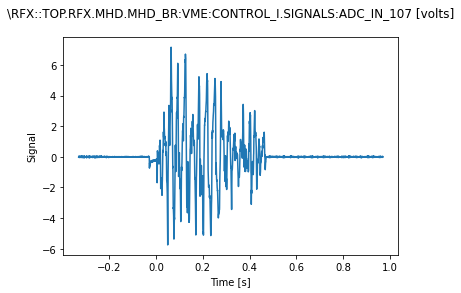

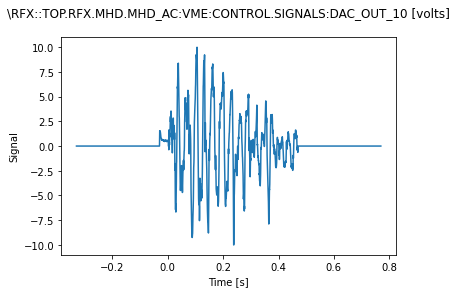

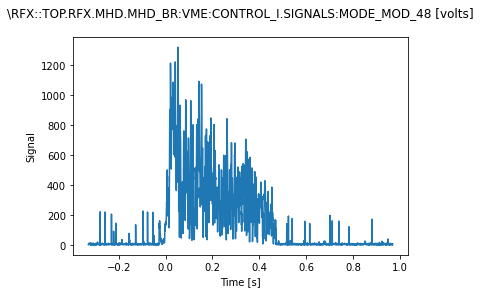

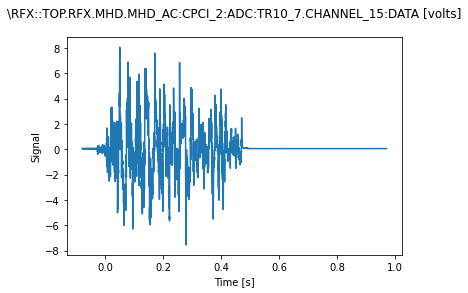

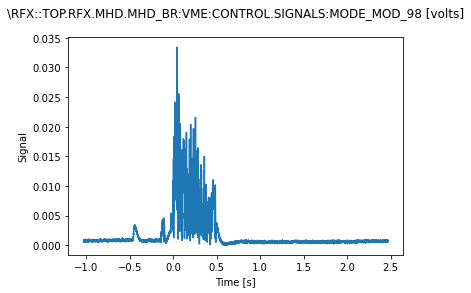

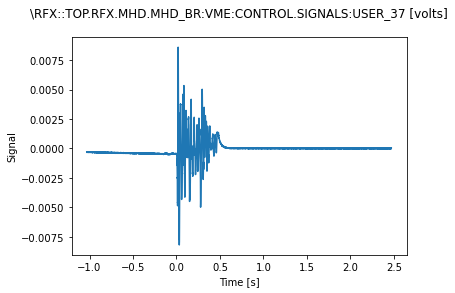

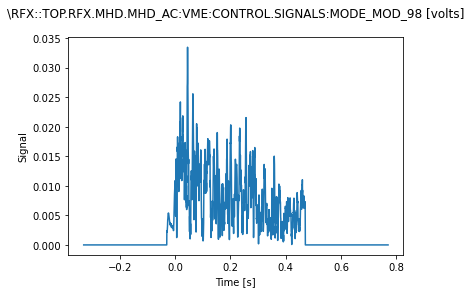

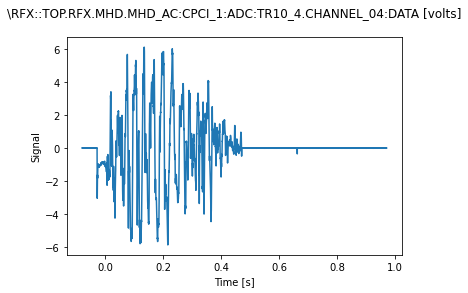

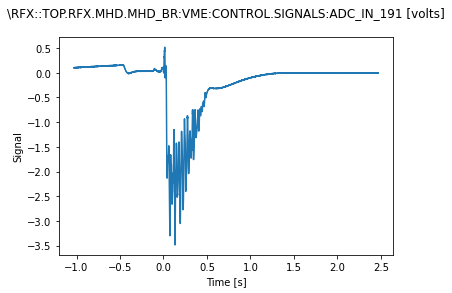

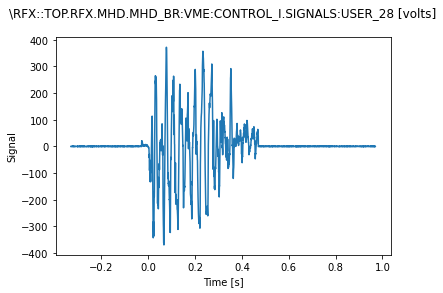

In [11]:
# extract data from the signals and plot them
MAX_LOAD = 10 #10 #np.inf
MAX_LOAD = min(MAX_LOAD, len(raw_signals))
# select MAX_LOAD random signals
signals = random.sample(raw_signals, MAX_LOAD)
for node in (signals):
    signal = node.data()
    times = node.dim_of().data()
    unit = node.getUnits()
    full_path = node.getFullPath()
    try: node_help = node.getHelp()
    except: node_help = ''
    if signal.shape != times.shape:
        print(f'{full_path} has mismatched signal and time shapes')
        continue
    # plot the signal
    plt.figure()
    plt.plot(times, signal)
    plt.title(f'{full_path} [{unit}]\n{node_help}')
    plt.xlabel('Time [s]')
    plt.ylabel('Signal')
    plt.show()

## Exploring Text

In [12]:
text_nodes = rfx.getNodeWild(search_space, 'Text') # get all the 'TEXT' nodes
print(f'Found {len(text_nodes)} of the type Text in the search space {search_space}')
# print all the text nodes
for node in text_nodes:
    try: print(f'{node.getFullPath()}={node.data()}')
    except: pass

Found 2669 of the type Text in the search space \TOP.RFX.MHD.***
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:COMMENT=#1 SlinkyRot #2 Zanca2008 #3 Hybrid 2010
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:FEEDFORW=DISABLED
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:ROUTINE_NAME=MhdAc
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:VERSION=2.3.0
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:VME_IP=150.178.34.29
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:DESCRIPTION=Null waveforms
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:VME_IP=150.178.34.29
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:CLOCK_MODE=EXTERNAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:COMMENT=
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:IP_ADDR=
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:SW_MODE=LOCAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:TRIG_EDGE=RISING
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:TRIG_MODE=EXTERNAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:USE_TIME=TRUE
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_10:CLOCK_MODE=EXTERNAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10

## Exploring Times

In [13]:
import MDSplus as mds
import numpy as np
import sys
from tqdm import tqdm
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')
np.set_printoptions(precision=3, suppress=True)

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
MDSplus version: 1.0.0


In [14]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only
from convert_to_hdf5 import SEG_FAULT_NODES
MAX_DEPTH = 13 # maximum depth of the tree to traverse

In [15]:
times_diff_stds = []
times_lengths = []
def traverse_get_times(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        next_nodes = []
        for node in tqdm(curr_nodes, ncols=80, desc=f'Depth:{d}'):
            if node.getFullPath() in SEG_FAULT_NODES: continue # skip the nodes that cause segfault
            try: #get the times of the node
                times = node.dim_of().data()
                try :
                    assert times.ndim == 1, f'ignored: times.ndim={times.ndim}'
                    assert len(times) > 1000, f'ignored: len(times)={len(times)}'
                    times_diff_stds.append(np.std(np.diff(times)))
                    times_lengths.append(len(times))
                except Exception as e:
                    print(f'{node.getFullPath()} ERR: {e}')
                    pass
            except: pass
            try: # get the children of the node
                for child in node.getChildren(): next_nodes.append(child)
            except: pass
            try:# get the members of the node
                for member in node.getMembers(): next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes

traverse_get_times(MAX_DEPTH, rfx.getNode('\\TOP.RFX')) # get the top node)

Depth:3:  58%|█████████████████▉             | 360/623 [00:02<00:01, 205.04it/s]

\RFX::TOP.RFX.SETUP:UNITS:A_PARS ERR: ignored: len(times)=288
\RFX::TOP.RFX.SETUP:UNITS:B_PARS ERR: ignored: len(times)=192


Depth:3:  67%|████████████████████▋          | 416/623 [00:02<00:01, 153.38it/s]

\RFX::TOP.RFX.STC:DIO2_1:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_1:REC_TIMES ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_2:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_2:REC_TIMES ERR: ignored: len(times)=9


Depth:3:  70%|█████████████████████▌         | 433/623 [00:03<00:01, 145.50it/s]

\RFX::TOP.RFX.STC:DIO2_3:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_3:REC_TIMES ERR: ignored: len(times)=9


Depth:3:  74%|██████████████████████▉        | 462/623 [00:03<00:01, 113.26it/s]

\RFX::TOP.RFX.STC:DIO2_4:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_4:REC_TIMES ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_5:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_5:REC_TIMES ERR: ignored: len(times)=9


Depth:3:  81%|█████████████████████████▏     | 506/623 [00:03<00:00, 119.16it/s]

\RFX::TOP.RFX.STC:DIO2_6:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_6:REC_TIMES ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_7:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.STC:DIO2_7:REC_TIMES ERR: ignored: len(times)=9


Depth:3:  96%|█████████████████████████████▋ | 596/623 [00:04<00:00, 163.47it/s]

\RFX::TOP.RFX.STC:TIMING:EVENT_NAMES ERR: ignored: len(times)=13
\RFX::TOP.RFX.STC:TIMING:EVENT_TIMES ERR: ignored: len(times)=13


Depth:4:   7%|██                            | 164/2422 [00:01<00:15, 142.76it/s]

\RFX::TOP.RFX.DIAG.DCCD.SIGNALS:SPECTRUM_1 ERR: ignored: len(times)=200
\RFX::TOP.RFX.DIAG.DCCD.SIGNALS:SPECTRUM_M ERR: ignored: len(times)=60


Depth:4:   8%|██▍                           | 198/2422 [00:01<00:14, 155.51it/s]

\RFX::TOP.RFX.DIAG.DESO.RESULTS:F_NM_FLUX ERR: ignored: len(times)=127
\RFX::TOP.RFX.DIAG.DESO.RESULTS:F_TM_FLUX ERR: ignored: len(times)=127
\RFX::TOP.RFX.DIAG.DESO.RESULTS:P_NM_FLUX ERR: ignored: len(times)=127
\RFX::TOP.RFX.DIAG.DESO.RESULTS:P_TM_FLUX ERR: ignored: len(times)=127


Depth:4:  10%|███                           | 245/2422 [00:01<00:19, 112.05it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS:PP_T_BASE ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS:PP_T_BASE2 ERR: ignored: len(times)=4


Depth:4:  14%|████▎                         | 351/2422 [00:02<00:14, 142.88it/s]

\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ANG_LAMINE ERR: ignored: len(times)=40
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ANG_MATRIX ERR: ignored: len(times)=40
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:CALIB_CHISQ ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:CALIB_FACTS ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:CALIB_ZERO ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ERR01 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ERR02 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ERR03 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ERR04 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ERR05 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ERR06 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:SGN01 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:SGN02 ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:SGN03 ERR: ignored: len(times)=1
\RFX:

Depth:4:  17%|█████▏                        | 419/2422 [00:03<00:14, 140.82it/s]

\RFX::TOP.RFX.DIAG.DSFM.SIGNALS:GC2_9 ERR: ignored: len(times)=985
\RFX::TOP.RFX.DIAG.DSFM.SIGNALS:GLI_9_82 ERR: ignored: len(times)=925


Depth:4:  19%|█████▌                        | 449/2422 [00:03<00:16, 120.62it/s]

\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_00 ERR: ignored: len(times)=30
\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_01 ERR: ignored: len(times)=30
\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_02 ERR: ignored: len(times)=14
\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_03 ERR: ignored: len(times)=30


Depth:4:  20%|█████▊                        | 474/2422 [00:03<00:17, 112.50it/s]

\RFX::TOP.RFX.DIAG.DSXC.RESULTS:PREL ERR: ignored: len(times)=9
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:PROF_TE ERR: ignored: len(times)=276
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TIME_TE ERR: ignored: len(times)=276
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:CHECK_TYPE ERR: ignored: len(times)=3


Depth:4:  21%|██████▎                       | 511/2422 [00:04<00:14, 128.75it/s]

\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:TE_DF$ ERR: ignored: len(times)=301
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:TE_DF_ERR$ ERR: ignored: len(times)=301
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:TE_LIST ERR: ignored: len(times)=10
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM150_300 ERR: ignored: len(times)=301
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM150_300_E ERR: ignored: len(times)=301
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM37_75 ERR: ignored: len(times)=329
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM37_75_E ERR: ignored: len(times)=329
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM75_150 ERR: ignored: len(times)=332
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM75_150_E ERR: ignored: len(times)=332


Depth:4:  23%|██████▉                       | 564/2422 [00:04<00:16, 111.91it/s]

\RFX::TOP.RFX.DIAG.DTSR.RESULTS:CSQR ERR: ignored: len(times)=78
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:DNE ERR: ignored: len(times)=78
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:DTE ERR: ignored: len(times)=78
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:LASER_ENERGY ERR: ignored: len(times)=41
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:LASER_TIMES ERR: ignored: len(times)=41
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:NE ERR: ignored: len(times)=78
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:TE ERR: ignored: len(times)=78


Depth:4:  29%|████████▉                      | 701/2422 [00:06<00:17, 98.18it/s]

\RFX::TOP.RFX.SETUP.MHD:CONFIG:CHOP_STATE ERR: ignored: len(times)=192
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_109_120 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_121_132 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_133_144 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_13_24 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_145_156 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_157_168 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_169_180 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_181_192 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_1_12 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_25_36 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_37_48 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_49_60 ERR: ignored: len(times)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_61_72 ERR: ignored: len(times)=552
\RFX::

Depth:4:  34%|██████████▏                   | 819/2422 [00:06<00:08, 181.80it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PC_FF_SETUP:OUT_GAINS ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_FF_SETUP:WAVE ERR: ignored: len(times)=2
\RFX::TOP.RFX.SETUP.POLOIDAL:PM_SETUP:OUT_GAINS ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PM_SETUP:WAVE ERR: ignored: len(times)=5


Depth:4:  35%|██████████▋                   | 858/2422 [00:07<00:08, 179.31it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP:OUT_GAINS ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP:OUT_GAINS ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.TOROIDAL:CHOPPER:OUT_CALIB ERR: ignored: len(times)=24
\RFX::TOP.RFX.SETUP.TOROIDAL:CHOPPER:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:DC8MF1 ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:DC8MF2 ERR: ignored: len(times)=6


Depth:4:  36%|██████████▉                   | 878/2422 [00:07<00:08, 184.61it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:REC_PARAMS1 ERR: ignored: len(times)=450
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:REC_PARAMS2 ERR: ignored: len(times)=450
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:SEND_PARAMS1 ERR: ignored: len(times)=66
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:SEND_PARAMS2 ERR: ignored: len(times)=66


Depth:4:  39%|███████████▊                  | 955/2422 [00:07<00:08, 173.85it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:TF_SETUP:WAVE ERR: ignored: len(times)=11
\RFX::TOP.RFX.SETUP.VESSEL:VI_SETUP:FILL_WAVE ERR: ignored: len(times)=8
\RFX::TOP.RFX.SETUP.VESSEL:VI_SETUP:PUFF_WAVE ERR: ignored: len(times)=17


Depth:4:  44%|████████████▉                | 1077/2422 [00:08<00:06, 199.11it/s]

\RFX::TOP.RFX.SETUP:DIAG_TIMES.DTSR:DELAY_PULSE ERR: ignored: len(times)=10


Depth:4:  48%|█████████████▉               | 1166/2422 [00:08<00:07, 171.36it/s]

\RFX::TOP.RFX.STC.STC_DIAG:DIO2_1:REC_TIMES ERR: ignored: len(times)=0
\RFX::TOP.RFX.STC.STC_DIAG:DIO2_2:REC_TIMES ERR: ignored: len(times)=0


Depth:5:   1%|▏                              | 45/5658 [00:00<00:34, 164.16it/s]

\RFX::TOP.RFX.DIAG.A.RESULTS.DFLU_SIGNALS:ALPHA_PROBES ERR: ignored: len(times)=4


Depth:5:  12%|███▌                          | 664/5658 [00:05<00:35, 141.75it/s]

\RFX::TOP.RFX.DIAG.DGPI.PARAMETERS.GEOMETRY:FOCUS_CENTER ERR: ignored: len(times)=2


Depth:5:  15%|████▍                         | 834/5658 [00:06<00:37, 128.99it/s]

\RFX::TOP.RFX.DIAG.DICO28.PARAMETERS.CONFIG:MCHORD_H ERR: ignored: len(times)=18
\RFX::TOP.RFX.DIAG.DICO28.PARAMETERS.CONFIG:MCHORD_NAMES ERR: ignored: len(times)=18
\RFX::TOP.RFX.DIAG.DICO28.PARAMETERS.CONFIG:MCHORD_TH ERR: ignored: len(times)=18


Depth:5:  15%|████▌                         | 869/5658 [00:06<00:34, 137.07it/s]

\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:ALPHAS_INV ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:BETAS_INV ERR: ignored: len(times)=9
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_ERRORS ERR: ignored: len(times)=13
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_NAMES ERR: ignored: len(times)=14
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_TMED ERR: ignored: len(times)=13
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_TZERO ERR: ignored: len(times)=13
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:LOC_NAMES ERR: ignored: len(times)=14


Depth:5:  16%|████▊                         | 918/5658 [00:06<00:32, 144.01it/s]

\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_0B ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_1 ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_1B ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_2 ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_2B ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_3 ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_3B ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_4 ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_4B ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_5 ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_5B ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_6 ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.

Depth:5:  17%|█████▏                         | 958/5658 [00:07<00:56, 83.59it/s]

\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:ALPHA ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:BETA ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:CHIQ ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:D1 ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:DA ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:ERR ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N0 ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N1 ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:NA ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N_AVE ERR: ignored: len(times)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N_PEAK ERR: ignored: len(times)=242


Depth:5:  28%|████████                     | 1570/5658 [00:32<00:30, 135.48it/s]

\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DAC:ARRAY_SIZE ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DIO:DIRECTION ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DIO:STATE ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:I0 ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:PHI0 ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:PHI1 ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:ZETA ERR: ignored: len(times)=4


Depth:5:  29%|████████▍                    | 1657/5658 [00:32<00:24, 160.48it/s]

\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:FILTER_T ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:LENS_F ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:LENS_IRIS ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_2LENS ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_CAL ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_NAMES ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_PA ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_TA ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_X ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_Y ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_Z ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:WINDOW_T ERR: ignored: len(times)=4


Depth:5:  30%|████████▋                    | 1707/5658 [00:33<00:26, 150.14it/s]

\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.PARAMETERS:DELTA ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.PARAMETERS:TIMES ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.PARAMETERS.PARAM_CT:INSTR_W_CT ERR: ignored: len(times)=9


Depth:5:  32%|█████████▏                   | 1785/5658 [00:33<00:21, 182.67it/s]

\RFX::TOP.RFX.DIAG.DSFM.PARAMETERS.PARAM_DSFM:CONTCHORD ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSFM.PARAMETERS.PARAM_DSFM:HACHORD ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DSFM.PARAMETERS.PARAM_DSFM:PHALFA ERR: ignored: len(times)=3


Depth:5:  35%|██████████                   | 1965/5658 [00:34<00:19, 193.94it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.CALC_TE:CHECK_TYPE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.CALC_TE:EXCL_LOG ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:ERR_TE ERR: ignored: len(times)=273
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:TE ERR: ignored: len(times)=273
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:ERR_TE ERR: ignored: len(times)=247
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:TE ERR: ignored: len(times)=247
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:ERR_TE ERR: ignored: len(times)=245
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:TE ERR: ignored: len(times)=2

Depth:5:  35%|██████████▎                  | 2007/5658 [00:34<00:18, 200.66it/s]

\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_06:TE ERR: ignored: len(times)=249
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:ERR_TE ERR: ignored: len(times)=250
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:TE ERR: ignored: len(times)=250
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:ERR_TE ERR: ignored: len(times)=208
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:TE ERR: ignored: len(times)=208
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:ERR_TE ERR: ignored: len(times)=35
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:TE ERR: ignored: len(times)=35


Depth:5:  36%|██████████▌                  | 2050/5658 [00:35<00:18, 193.87it/s]

\RFX::TOP.RFX.DIAG.DSXM.DSXM_RAW.PARAMETERS:FEMTO_SET ERR: ignored: len(times)=8


Depth:5:  39%|███████████▏                 | 2187/5658 [00:35<00:18, 183.88it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.BRIGHT:EXCL_LOG ERR: ignored: len(times)=38
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.BRIGHT:TIME ERR: ignored: len(times)=98
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.CALC_TE:CHECK_TYPE ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.CALC_TE:EXCL_LOG ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.BRIGHT:PROF_H ERR: ignored: len(times)=98
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.BRIGHT:PROF_V ERR: ignored: len(times)=98
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.BRIGHT:P_H ERR: ignored: len(times)=16
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.BRIGHT:P_V ERR: ignored: len(times)=49
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.INVERT:EMISS ERR: ignored: len(times)=98
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.INVERT:X_AXIS ERR: ignored: len(times)=110
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.INVERT:Y_AXIS ERR: ignored: len(times)=110
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:ERR_TE ERR: ignored: len(times)=852
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:PREL ERR: ignored: len(times)=17
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE

Depth:5:  40%|███████████▍                 | 2242/5658 [00:36<00:19, 172.95it/s]

\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TIME_TE ERR: ignored: len(times)=852


Depth:5:  41%|████████████                 | 2347/5658 [00:36<00:23, 140.43it/s]

\RFX::TOP.RFX.DIAG.DTSR.PARAMETERS.NEODIMIUM:RAD_POS ERR: ignored: len(times)=78
\RFX::TOP.RFX.DIAG.DTSR.PARAMETERS.NEODIMIUM:STRAY ERR: ignored: len(times)=2


Depth:5:  57%|████████████████▉             | 3200/5658 [00:45<00:29, 83.50it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:5:  60%|█████████████████▉            | 3393/5658 [00:49<00:49, 46.17it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:5:  64%|███████████████████           | 3594/5658 [00:51<00:31, 64.97it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:ZERO ERR: ignored: len(times)=384
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I011 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I012 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I013 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I014 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I021 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I022 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I023 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I024 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I031 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I032 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I033 ERR: ignored: len(times)=88
\RFX::TOP.RF

Depth:5:  64%|██████████████████▋          | 3635/5658 [00:52<00:20, 100.86it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I052 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I053 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I054 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I061 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I062 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I063 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I064 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I071 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I072 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I073 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I074 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I081 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I082 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I083 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  65%|██████████████████▊          | 3677/5658 [00:52<00:14, 137.08it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I154 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I161 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I162 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I163 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I164 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I171 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I172 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I173 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I174 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I181 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I182 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I183 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I184 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I191 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  66%|███████████████████          | 3718/5658 [00:52<00:11, 162.67it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I254 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I261 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I262 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I263 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I264 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I271 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I272 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I273 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I274 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I281 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I282 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I283 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I284 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I291 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  66%|███████████████████▎         | 3760/5658 [00:52<00:10, 181.29it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I361 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I362 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I363 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I364 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I371 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I372 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I373 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I374 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I381 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I382 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I383 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I384 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I391 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I392 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  67%|███████████████████▎         | 3780/5658 [00:52<00:10, 185.97it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I462 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I463 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I464 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I471 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I472 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I473 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I474 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I481 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I482 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I483 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I484 ERR: ignored: len(times)=88


Depth:5:  71%|█████████████████████▍        | 4038/5658 [00:55<00:20, 79.48it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL:ZERO ERR: ignored: len(times)=384
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I011 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I012 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I013 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I014 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I021 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I022 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I023 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I024 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I031 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I032 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I033 ERR: ignored: len(times)=88
\RFX::TOP.RF

Depth:5:  72%|████████████████████▉        | 4080/5658 [00:56<00:13, 116.76it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I052 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I053 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I054 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I061 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I062 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I063 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I064 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I071 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I072 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I073 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I074 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I081 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I082 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I083 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  73%|█████████████████████▏       | 4122/5658 [00:56<00:10, 149.27it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I153 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I154 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I161 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I162 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I163 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I164 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I171 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I172 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I173 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I174 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I181 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I182 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I183 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I184 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  74%|█████████████████████▎       | 4164/5658 [00:56<00:08, 172.61it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I254 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I261 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I262 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I263 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I264 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I271 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I272 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I273 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I274 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I281 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I282 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I283 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I284 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I291 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  74%|█████████████████████▌       | 4206/5658 [00:56<00:07, 186.34it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I362 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I363 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I364 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I371 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I372 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I373 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I374 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I381 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I382 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I383 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I384 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I391 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I392 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I393 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  75%|█████████████████████▋       | 4227/5658 [00:56<00:08, 168.10it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I463 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I464 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I471 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I472 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I473 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I474 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I481 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I482 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I483 ERR: ignored: len(times)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I484 ERR: ignored: len(times)=88


Depth:5:  76%|██████████████████████▋       | 4273/5658 [00:58<00:30, 44.81it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:5:  76%|██████████████████████▉       | 4321/5658 [00:59<00:27, 48.69it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I:ZERO ERR: ignored: len(times)=384
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.BV_ADD:WAVE ERR: ignored: len(times)=8
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_IP:WAVE ERR: ignored: len(times)=8
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS1:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS2:WAVE ERR: ignored: len(times)=6


Depth:5:  78%|██████████████████████▌      | 4390/5658 [00:59<00:11, 112.67it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS3:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS4:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS5:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS6:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS7:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS8:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS1_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS2_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS3_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS4_ADD:WAVE ERR: ignored: len(times)=6


Depth:5:  78%|██████████████████████▋      | 4437/5658 [01:00<00:07, 156.07it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS5_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS6_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS7_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS8_ADD:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.REF_DELTA_H:WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.POLOIDAL:IP_CONTROL.RFP:WAVE ERR: ignored: len(times)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:IP_CONTROL.TOKAMAK:WAVE ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_1:OUT_GAINS ERR: ignored: len(times)=3


Depth:5:  79%|██████████████████████▉      | 4485/5658 [01:00<00:06, 190.12it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_1:WAVE ERR: ignored: len(times)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_2:WAVE ERR: ignored: len(times)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_3:WAVE ERR: ignored: len(times)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_4:WAVE ERR: ignored: len(times)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_1:WAVE ERR: ignored: len(times)=4
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_2:WAVE ERR: ignored: len(times)=3


Depth:5:  80%|███████████████████████▏     | 4532/5658 [01:00<00:05, 208.37it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_3:WAVE ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_4:WAVE ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_5:WAVE ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_6:WAVE ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_7:WAVE ERR: ignored: len(times)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_8:WAVE ERR: ignored: len(times)=4
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_1:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_2:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_3:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_4:WAVE ERR: ignored: len(times)=6


Depth:5:  81%|███████████████████████▍     | 4579/5658 [01:00<00:04, 217.80it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_5:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_6:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_7:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_8:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.F:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.FLUX:WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.Q:WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.WALLBT:WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_1:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_10:WAVE ERR: ignored: len(times)=6


Depth:5:  82%|███████████████████████▋     | 4626/5658 [01:00<00:04, 224.39it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_11:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_12:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_2:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_3:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_4:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_5:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_6:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_7:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_8:WAVE ERR: ignored: len(times)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_9:WAVE ERR: ignored: len(times)=6


Depth:5:  83%|████████████████████████     | 4695/5658 [01:01<00:04, 220.43it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_1:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_1:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_10:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_10:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_11:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_11:WAVE ERR: ignored: len(times)=10


Depth:5:  84%|████████████████████████▎    | 4741/5658 [01:01<00:04, 219.43it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_12:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_12:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_2:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_2:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_3:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_3:WAVE ERR: ignored: len(times)=10


Depth:5:  85%|████████████████████████▌    | 4787/5658 [01:01<00:03, 221.46it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_4:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_4:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_5:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_5:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_6:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_6:WAVE ERR: ignored: len(times)=10


Depth:5:  86%|████████████████████████▉    | 4856/5658 [01:02<00:03, 221.82it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_7:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_7:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_8:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_8:WAVE ERR: ignored: len(times)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_9:P_WAVE ERR: ignored: len(times)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_9:WAVE ERR: ignored: len(times)=10


Depth:5:  87%|█████████████████████████    | 4901/5658 [01:02<00:03, 218.94it/s]

\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_04:NAME ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_04:POSITION ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_04:VD_MODULE ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_05:NAME ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_05:POSITION ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_05:VD_MODULE ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_06:NAME ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_06:POSITION ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_06:VD_MODULE ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_07:NAME ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_07:POSITION ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_07:VD_MODULE ERR: ignored: len(times)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_08:NAME ERR: ignored: le

Depth:6:   0%|                             | 104/26230 [00:01<02:34, 169.32it/s]

\RFX::TOP.RFX.DIAG.DBOT.DBOT_RAW.ACQUISITION:MCU:FILTER_POS ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DBOT.DBOT_RAW.ACQUISITION:MCU:MAN_POS ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DBOT.DBOT_RAW.ACQUISITION:MCU:RS232_LINKS ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_01:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_02:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_03:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_04:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_05:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_06:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_07:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   1%|▏                            | 149/26230 [00:01<02:12, 196.45it/s]

\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_08:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_09:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_10:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_11:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_12:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_13:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_14:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_15:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   1%|▏                            | 195/26230 [00:01<02:03, 211.22it/s]

\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_16:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_17:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_18:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_19:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_20:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_21:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_22:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_23:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   1%|▎                            | 241/26230 [00:01<01:59, 218.37it/s]

\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_24:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_25:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_26:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_27:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_28:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_29:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_30:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_31:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   1%|▎                            | 287/26230 [00:01<01:56, 222.18it/s]

\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_32:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_33:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_34:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_35:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_36:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_37:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_38:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_39:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   1%|▎                            | 334/26230 [00:02<01:54, 226.77it/s]

\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_40:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_41:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_42:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_43:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_44:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_45:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_46:CAL_GAIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_47:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   1%|▍                            | 380/26230 [00:02<02:02, 211.19it/s]

\RFX::TOP.RFX.DIAG.DBOT.PARAMETERS.CHANNELS.CH_48:CAL_GAIN ERR: ignored: len(times)=8


Depth:6:   2%|▌                            | 490/26230 [00:02<02:01, 211.93it/s]

\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_1:CLOCK_SOURCE ERR: ignored: len(times)=211
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_1:DATA ERR: ignored: len(times)=200
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_1:ROI ERR: ignored: len(times)=60
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_1:SPEC_MIR_POS ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_1:XCAL_COEFF ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_2:CLOCK_SOURCE ERR: ignored: len(times)=221
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:CCD_2:ROI ERR: ignored: len(times)=60


Depth:6:   2%|▌                            | 559/26230 [00:03<01:55, 221.76it/s]

\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:HMSPECTRO:DATA ERR: ignored: len(times)=60
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:PIXIS:CLOCK_SOURCE ERR: ignored: len(times)=11
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.ACQUISITION:PIXIS:ROI ERR: ignored: len(times)=0
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.TIMING:CCD_CLOCK_1:CLOCK ERR: ignored: len(times)=211


Depth:6:   2%|▋                            | 605/26230 [00:03<01:55, 221.16it/s]

\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.TIMING:CCD_CLOCK_2:CLOCK ERR: ignored: len(times)=221
\RFX::TOP.RFX.DIAG.DCCD.DCCD_RAW.TIMING:PIXIS_CLOCK:CLOCK ERR: ignored: len(times)=11


Depth:6:   4%|█                           | 1003/26230 [00:05<02:38, 159.59it/s]

\RFX::TOP.RFX.DIAG.DEDG.TRIPLE_PROBE.RESULTS.ACQ_PP:IS_TP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.TRIPLE_PROBE.RESULTS.ACQ_PP:VF_TP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.TRIPLE_PROBE.RESULTS.ACQ_PP:VP_TP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.TRIPLE_PROBE.RESULTS.PP:IS_TP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.TRIPLE_PROBE.RESULTS.PP:VF_TP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.TRIPLE_PROBE.RESULTS.PP:VP_TP ERR: ignored: times.ndim=2


Depth:6:   5%|█▍                           | 1244/26230 [00:08<04:24, 94.56it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW.PARAMETERS:DESO_VISETUP:FILL_WAVE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW.PARAMETERS:DESO_VISETUP:PUFF_WAVE ERR: ignored: len(times)=17


Depth:6:   7%|█▉                          | 1820/26230 [00:11<02:41, 150.82it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BP01:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BP01:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BP02:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BP02:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1837/26230 [00:12<07:45, 52.36it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BP03:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BP03:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BR01:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BR01:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1849/26230 [00:13<10:44, 37.85it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BR02:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BR02:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1858/26230 [00:13<11:58, 33.91it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BR03:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BR03:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BT01:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BT01:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1865/26230 [00:14<15:45, 25.77it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BT02:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BT02:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1871/26230 [00:14<16:37, 24.42it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BT03:DB_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.MAG.BT03:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1877/26230 [00:14<17:23, 23.35it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_01:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_01:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1883/26230 [00:15<18:00, 22.54it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_02:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_02:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1889/26230 [00:15<18:23, 22.06it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_03:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1895/26230 [00:15<18:53, 21.48it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_04:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_04:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1901/26230 [00:15<19:27, 20.83it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_05:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_05:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1907/26230 [00:16<20:03, 20.21it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_06:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1913/26230 [00:16<20:43, 19.55it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_07:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_07:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██                           | 1919/26230 [00:16<21:09, 19.14it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_08:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_08:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1925/26230 [00:17<21:02, 19.25it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_09:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_09:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1931/26230 [00:17<20:59, 19.29it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_10:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_10:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1937/26230 [00:17<20:45, 19.50it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_11:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_11:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1943/26230 [00:18<20:59, 19.28it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_12:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_12:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1949/26230 [00:18<20:46, 19.48it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_13:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_13:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1955/26230 [00:18<20:49, 19.43it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_14:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_14:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1961/26230 [00:19<20:52, 19.38it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_15:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_15:V_PP ERR: ignored: times.ndim=2


Depth:6:   7%|██▏                          | 1967/26230 [00:19<21:15, 19.03it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_16:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_12.CH_16:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 1973/26230 [00:19<21:26, 18.86it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_01:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_01:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 1979/26230 [00:20<21:31, 18.77it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_02:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_02:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 1985/26230 [00:20<21:16, 18.99it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_03:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 1991/26230 [00:20<21:09, 19.09it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_04:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_04:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 1997/26230 [00:20<20:56, 19.28it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_05:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_05:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 2003/26230 [00:21<20:45, 19.46it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_06:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 2009/26230 [00:21<20:34, 19.62it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_07:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_07:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 2015/26230 [00:21<20:42, 19.49it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_08:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_08:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 2021/26230 [00:22<20:33, 19.62it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_09:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_09:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 2027/26230 [00:22<20:54, 19.30it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_10:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_10:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▏                          | 2033/26230 [00:22<21:13, 19.01it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_11:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_11:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2039/26230 [00:23<21:27, 18.80it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_12:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_12:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2045/26230 [00:23<21:25, 18.82it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_13:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_13:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2051/26230 [00:23<21:06, 19.08it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_14:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_14:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2057/26230 [00:24<21:08, 19.05it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_15:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_15:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2069/26230 [00:24<17:24, 23.14it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_16:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_34.CH_16:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_01:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_01:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2081/26230 [00:24<12:38, 31.83it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_02:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_02:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_03:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2093/26230 [00:25<10:18, 39.00it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_04:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_04:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_05:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_05:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2105/26230 [00:25<09:14, 43.52it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_06:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_07:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_07:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2117/26230 [00:25<09:15, 43.44it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_08:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_A.CH_08:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_01:I_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2123/26230 [00:25<09:18, 43.17it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_01:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_02:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_02:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2135/26230 [00:25<09:24, 42.71it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_03:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_04:I_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▎                          | 2147/26230 [00:26<09:18, 43.14it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_04:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_05:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_05:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▍                          | 2153/26230 [00:26<09:25, 42.59it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_06:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_07:I_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▍                          | 2165/26230 [00:26<09:19, 43.01it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_07:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_08:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_B.CH_08:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▍                          | 2171/26230 [00:26<08:59, 44.62it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_01:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_01:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_02:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_02:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▍                          | 2183/26230 [00:27<08:35, 46.65it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_03:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_04:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_04:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▍                          | 2195/26230 [00:27<08:44, 45.83it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_05:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_05:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_06:V_PP ERR: ignored: times.ndim=2


Depth:6:   8%|██▍                          | 2207/26230 [00:27<08:26, 47.40it/s]

\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_07:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_07:V_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_08:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.SIGNALS.PMT_C.CH_08:V_PP ERR: ignored: times.ndim=2


Depth:6:   9%|██▍                         | 2292/26230 [00:28<02:32, 156.52it/s]

\RFX::TOP.RFX.DIAG.DICO28.DICO28_RAW.TIMING:TIMER:REC_TIMES ERR: ignored: len(times)=0
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_0:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_0:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_0B:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_0B:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_1:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_1:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_1B:CO2_OFFSET ERR: ignored: len(times)=2


Depth:6:   9%|██▍                         | 2338/26230 [00:28<02:04, 192.01it/s]

\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_1B:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_2:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_2:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_2B:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_2B:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_3:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_3:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_4:CO2_OFFSET ERR: ignored: len(times)=2


Depth:6:   9%|██▌                         | 2384/26230 [00:28<01:54, 207.39it/s]

\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_4:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_4B:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_4B:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_5:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_5:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_5B:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_5B:COM_OFFSET ERR: ignored: len(times)=2


Depth:6:   9%|██▌                         | 2429/26230 [00:28<01:50, 214.85it/s]

\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_6:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_6:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_6B:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_6B:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_7:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_7:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_7B:CO2_OFFSET ERR: ignored: len(times)=2


Depth:6:   9%|██▋                         | 2475/26230 [00:28<01:48, 219.66it/s]

\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_7B:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_8:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_8:COM_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_8B:CO2_OFFSET ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.CO2_PROG.CHORD_8B:COM_OFFSET ERR: ignored: len(times)=2


Depth:6:  18%|████▉                       | 4661/26230 [00:39<02:10, 165.45it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES018 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES028 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES038 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES048 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES058 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES068 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES078 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES088 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES098 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES108 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES118 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES128 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ

Depth:6:  18%|████▉                       | 4678/26230 [00:39<02:19, 154.61it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES288 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES298 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES308 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES318 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES328 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES338 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES348 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES355 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES357 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES358 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES368 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES378 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ

Depth:6:  18%|█████                       | 4709/26230 [00:39<02:29, 143.74it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES548 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES558 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES568 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES588 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES598 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES608 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES618 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES628 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES638 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES648 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES658 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_ES668 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ

Depth:6:  18%|█████                       | 4739/26230 [00:39<02:31, 142.05it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EX504 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EX505 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EX507 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EX508 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EX728 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY501 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY502 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY504 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY505 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY506 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY507 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ_PP:VF_EY508 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.ACQ

Depth:6:  18%|█████▏                      | 4847/26230 [00:40<02:23, 148.62it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES018 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES028 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES038 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES048 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES058 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES068 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES078 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES088 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES098 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES108 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES118 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES128 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES138 ERR: ignored: times.ndim=2
\RFX::TOP.RF

Depth:6:  19%|█████▏                      | 4863/26230 [00:40<02:35, 137.16it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES258 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES268 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES278 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES288 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES298 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES308 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES318 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES328 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES338 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES348 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES355 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES357 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES358 ERR: ignored: times.ndim=2
\RFX::TOP.RF

Depth:6:  19%|█████▏                      | 4892/26230 [00:40<02:50, 124.95it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES468 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES478 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES488 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES498 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES518 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES528 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES538 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES548 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES558 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES568 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES588 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES598 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES608 ERR: ignored: times.ndim=2
\RFX::TOP.RF

Depth:6:  19%|█████▏                      | 4918/26230 [00:41<02:57, 120.17it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES718 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_ES719 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW501 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW502 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW504 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW505 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW506 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW507 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW508 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EW728 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EX501 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EX502 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EX504 ERR: ignored: times.ndim=2
\RFX::TOP.RF

Depth:6:  19%|█████▎                      | 4953/26230 [00:41<02:27, 144.73it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.ELS.PP:VF_EY728 ERR: ignored: times.ndim=2


Depth:6:  19%|█████▍                      | 5071/26230 [00:42<02:16, 155.54it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP431 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP432 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP433 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP434 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP435 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP436 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP437 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP438 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP441 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP448 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP450 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP451 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BP458 ERR: ignored: times.ndim=2

Depth:6:  19%|█████▍                      | 5088/26230 [00:42<02:26, 143.85it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT012 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT016 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT032 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT036 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT042 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT046 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT058 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT066 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT067 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT072 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT076 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT092 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT096 ERR: ignored: times.ndim=2

Depth:6:  20%|█████▍                      | 5118/26230 [00:42<02:35, 136.17it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT226 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT246 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT252 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT256 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT272 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT276 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT282 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT286 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT302 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT306 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT312 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT316 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT332 ERR: ignored: times.ndim=2

Depth:6:  20%|█████▍                      | 5146/26230 [00:42<02:38, 132.87it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT421 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT422 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT424 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT425 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT426 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT427 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT428 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT432 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT436 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT438 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT441 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT448 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT450 ERR: ignored: times.ndim=2

Depth:6:  20%|█████▌                      | 5174/26230 [00:42<02:38, 132.77it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT522 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT526 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT542 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT546 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT552 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT556 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT576 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT582 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT586 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT602 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT606 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT612 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.ACQ_PP:BT616 ERR: ignored: times.ndim=2

Depth:6:  21%|█████▊                      | 5441/26230 [00:44<01:33, 222.46it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP431 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP432 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP433 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP434 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP435 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP436 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP437 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP438 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP441 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP448 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP450 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP451 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP458 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BP459 ERR: 

Depth:6:  21%|█████▊                      | 5464/26230 [00:44<02:13, 155.87it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BR436 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BR437 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BR438 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT012 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT016 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT032 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT036 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT042 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT046 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT058 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT066 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT067 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT072 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT076 ERR: 

Depth:6:  21%|█████▊                      | 5500/26230 [00:44<02:38, 130.47it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT136 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT152 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT156 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT162 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT166 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT186 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT196 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT216 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT226 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT246 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT252 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT256 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT272 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT276 ERR: 

Depth:6:  21%|█████▉                      | 5515/26230 [00:44<02:46, 124.08it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT342 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT346 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT362 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT366 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT372 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT376 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT392 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT396 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT402 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT406 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT412 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT420 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT421 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT422 ERR: 

Depth:6:  21%|█████▉                      | 5542/26230 [00:45<02:59, 115.53it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT441 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT448 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT450 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT451 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT452 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT456 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT458 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT459 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT462 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT466 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT468 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT482 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT486 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT492 ERR: 

Depth:6:  21%|█████▉                      | 5566/26230 [00:45<03:04, 111.86it/s]

\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT556 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT576 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT582 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT586 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT602 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT606 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT612 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT616 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT632 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT636 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT642 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT646 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT662 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DISIS.RESULTS.MAG.PP:BT666 ERR: 

Depth:6:  23%|██████▍                     | 6046/26230 [00:50<01:49, 184.17it/s]

\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.ADC.V_LIMITS:V_MAX ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.ADC.V_LIMITS:V_MIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.ADC_1.V_LIMITS:V_MAX ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.ADC_1.V_LIMITS:V_MIN ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DAC.CHANNEL:ARRAY_SIZE ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.MOSS_PARAMS.CALIBRATION:BASELINE ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.MOSS_PARAMS.CALIBRATION:CONTRAST ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.MOSS_PARAMS.CALIBRATION:PHASE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.MOSS_PARAMS.CALIBRATION:PHASE_DRIVE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.MOSS_PARAMS.CALIBRATION:TIMING_ERR ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.MOSS_PARAMS.DEMODULATION:BSLN_TBNDS ERR: ignored: len(times)=2


Depth:6:  23%|██████▌                     | 6127/26230 [00:51<01:54, 175.02it/s]

\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:I0:E ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:PHI0:E ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:PHI1:E ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:ZETA:E ERR: ignored: len(times)=4


Depth:6:  26%|███████▏                    | 6734/26230 [00:54<01:46, 183.72it/s]

\RFX::TOP.RFX.DIAG.DSSP.DSSP_RAW.ACQUISITION:OMA:SCAN_MASK ERR: ignored: len(times)=3


Depth:6:  26%|███████▍                    | 6922/26230 [00:55<01:41, 190.15it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_01:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_02:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_03:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_04:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_05:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_06:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_07:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_08:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_09:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_10:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_11:CALIBRATION ERR: 

Depth:6:  27%|███████▍                    | 6967/26230 [00:55<01:34, 204.55it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_24:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_25:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_26:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_27:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_28:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_29:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_30:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_31:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_32:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_33:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_34:CALIBRATION ERR: 

Depth:6:  27%|███████▍                    | 7012/26230 [00:55<01:30, 211.54it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_47:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_48:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_49:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_50:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_51:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_52:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_53:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_54:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_55:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_56:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_57:CALIBRATION ERR: 

Depth:6:  27%|███████▌                    | 7057/26230 [00:56<01:28, 215.76it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_70:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_71:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_72:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_73:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_74:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_75:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_76:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_77:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_78:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_79:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_80:CALIBRATION ERR: 

Depth:6:  27%|███████▌                    | 7100/26230 [00:56<01:36, 198.71it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_93:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_94:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_95:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_96:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_97:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.AMPLIFIERS.AMP_98:CALIBRATION ERR: ignored: len(times)=20


Depth:6:  28%|███████▋                    | 7237/26230 [00:57<02:25, 130.34it/s]

\RFX::TOP.RFX.DIAG.DSXT.DSXT_RAW.ACQUISITION:MCU:FILTER_POS ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DSXT.DSXT_RAW.ACQUISITION:MCU:MAN_POS ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DSXT.DSXT_RAW.ACQUISITION:MCU:RS232_LINKS ERR: ignored: len(times)=7


Depth:6:  28%|███████▊                    | 7345/26230 [00:58<02:02, 153.74it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_01:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_02:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_03:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_04:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_05:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_06:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_07:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_08:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_09:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_10:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_11:CALIBRATION ERR: 

Depth:6:  28%|███████▉                    | 7389/26230 [00:58<01:42, 184.69it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_23:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_24:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_25:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_26:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_27:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_28:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_29:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_30:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_31:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_32:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_33:CALIBRATION ERR: 

Depth:6:  28%|███████▉                    | 7433/26230 [00:58<01:33, 200.82it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_45:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_46:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_47:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_48:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_49:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_50:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_51:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_52:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_53:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_54:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_55:CALIBRATION ERR: 

Depth:6:  29%|███████▉                    | 7477/26230 [00:58<01:29, 208.74it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_67:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_68:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_69:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_70:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_71:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_72:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_73:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_74:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_75:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_76:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_77:CALIBRATION ERR: 

Depth:6:  29%|████████                    | 7522/26230 [00:58<01:27, 213.72it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_89:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_90:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_91:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_92:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_93:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_94:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_95:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_96:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_97:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.AMPLIFIERS.AMP_98:CALIBRATION ERR: ignored: len(times)=20
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_02:BE ERR: ignored: len(times)=2

Depth:6:  29%|████████                    | 7566/26230 [00:59<01:27, 213.58it/s]

\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_06:ERR_TE ERR: ignored: len(times)=758
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_06:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_06:TE ERR: ignored: len(times)=758
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_07:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_07:ERR_TE ERR: ignored: len(times)=791
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_07:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_07:TE ERR: ignored: len(times)=791
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_08:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_08:ERR_TE ERR: ignored: len(times)=669
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_08:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_08:TE ERR: ignored: len(times)=669
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_09:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_09:ERR_TE ERR: ignored: len(times)=789
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_09:LOG

Depth:6:  29%|████████                    | 7610/26230 [00:59<01:28, 211.48it/s]

\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_14:TE ERR: ignored: len(times)=791
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_15:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_15:ERR_TE ERR: ignored: len(times)=786
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_15:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_15:TE ERR: ignored: len(times)=786
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_16:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_16:ERR_TE ERR: ignored: len(times)=687
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_16:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_16:TE ERR: ignored: len(times)=687
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_17:BE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_17:ERR_TE ERR: ignored: len(times)=637
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_17:LOG ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_17:TE ERR: ignored: len(times)=637
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TE_18:BE ERR:

Depth:6:  30%|████████▎                   | 7800/26230 [01:00<01:32, 198.72it/s]

\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_1:CLOCK_SOURCE ERR: ignored: len(times)=501
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_1:DATA ERR: ignored: len(times)=120
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_1:ROI ERR: ignored: len(times)=60
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_1:SPEC_MIR_POS ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_1:XCAL_COEFF ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_2:CLOCK_SOURCE ERR: ignored: len(times)=501
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_2:DATA ERR: ignored: len(times)=120
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_2:ROI ERR: ignored: len(times)=60


Depth:6:  30%|████████▎                   | 7845/26230 [01:00<01:27, 210.40it/s]

\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_2:SPEC_MIR_POS ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.ACQUISITION:XUV_2:XCAL_COEFF ERR: ignored: len(times)=6
\RFX::TOP.RFX.DIAG.DSXV.DSXV_RAW.TIMING:XUV_CLOCK_2:CLOCK ERR: ignored: len(times)=501


Depth:6:  31%|████████▋                   | 8188/26230 [01:02<02:06, 142.46it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.PARAMETERS.NEODINIUM:ND_PERIOD ERR: ignored: len(times)=10


Depth:6:  40%|██████████▊                | 10513/26230 [01:23<01:40, 156.09it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.TIMING:DIO2_1:REC_EVENTS ERR: ignored: len(times)=9
\RFX::TOP.RFX.EDA.EDA1.EDA1.TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=9


Depth:6:  40%|███████████▎                | 10553/26230 [01:24<03:58, 65.83it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:6:  41%|███████████▏               | 10868/26230 [01:26<01:41, 151.92it/s]

\RFX::TOP.RFX.EDA.EDA2:CPCI_1:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  42%|███████████▍               | 11099/26230 [01:28<01:39, 152.53it/s]

\RFX::TOP.RFX.EDA.EDA2:CPCI_2:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  44%|███████████▊               | 11450/26230 [01:30<01:34, 156.75it/s]

\RFX::TOP.RFX.EDA.EDA3:CPCI_1:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  45%|████████████▏              | 11840/26230 [01:32<01:32, 155.61it/s]

\RFX::TOP.RFX.EDA.EDA3:CPCI_2:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  45%|████████████▎              | 11908/26230 [01:32<01:13, 194.27it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=0
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR137_VAL ERR: ignored:

Depth:6:  46%|████████████▎              | 11952/26230 [01:33<01:10, 203.68it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR154_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR155_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR156_VAL ERR: ignored: len(t

Depth:6:  46%|████████████▎              | 11997/26230 [01:33<01:06, 213.55it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5


Depth:6:  46%|████████████▍              | 12064/26230 [01:33<01:06, 212.50it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=0
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR208_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR212_VAL ER

Depth:6:  46%|████████████▍              | 12108/26230 [01:33<01:07, 210.73it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192


Depth:6:  46%|████████████▌              | 12152/26230 [01:33<01:06, 212.50it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR242_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR243_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR249_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR250_VAL ERR: ignored: len(times)=6


Depth:6:  47%|████████████▋              | 12310/26230 [01:34<01:03, 219.35it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR312_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR313_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3


Depth:6:  47%|████████████▋              | 12354/26230 [01:34<01:04, 213.87it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR336_VAL ERR: ignored: len(t

Depth:6:  47%|████████████▋              | 12376/26230 [01:35<01:05, 210.40it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR345_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR346_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR347_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR348_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR349_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR41_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR42_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR43_VAL ERR: ignored: len(time

Depth:6:  47%|████████████▊              | 12420/26230 [01:35<01:06, 207.44it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR44_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR45_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR46_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR47_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR48_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR49_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR50_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=6
\RFX

Depth:6:  48%|████████████▊              | 12464/26230 [01:35<01:05, 209.82it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR64_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR65_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR66_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR67_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR68_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR69_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR70_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=6
\RFX

Depth:6:  48%|████████████▉              | 12509/26230 [01:35<01:03, 214.63it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR84_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR85_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR86_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR87_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR88_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=0


Depth:6:  54%|██████████████▋            | 14254/26230 [01:45<01:16, 157.41it/s]

\RFX::TOP.RFX.EDA.EDAM.CPCI_1.TIMING:DIO2_01:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  55%|██████████████▊            | 14408/26230 [01:45<00:55, 212.52it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR137_VAL ERR: ignore

Depth:6:  55%|██████████████▉            | 14452/26230 [01:46<00:55, 212.95it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR154_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR155_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR156_VAL ERR: ignored: len(t

Depth:6:  55%|██████████████▉            | 14497/26230 [01:46<00:54, 215.76it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=8


Depth:6:  55%|██████████████▉            | 14542/26230 [01:46<00:53, 217.81it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=17
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR208_VAL ERR: 

Depth:6:  56%|███████████████            | 14587/26230 [01:46<00:53, 218.98it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=17
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR22_VAL ERR

Depth:6:  56%|███████████████            | 14632/26230 [01:46<00:52, 219.91it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:6:  56%|███████████████▏           | 14702/26230 [01:47<00:51, 225.59it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:6:  56%|███████████████▏           | 14771/26230 [01:47<00:50, 227.14it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR299_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8


Depth:6:  56%|███████████████▎           | 14817/26230 [01:47<00:50, 224.73it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR32_VAL ERR: ignored: len(times)=3


Depth:6:  57%|███████████████▎           | 14863/26230 [01:47<00:51, 218.83it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR336_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR337_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR338_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR339_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR33_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR340_VAL ERR: ignored: len(ti

Depth:6:  57%|███████████████▎           | 14907/26230 [01:48<00:52, 217.62it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR35_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR36_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR37_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR38_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR39_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR41_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR42_VAL ERR: ignored: len(times)=3


Depth:6:  57%|███████████████▍           | 14951/26230 [01:48<00:52, 215.68it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR56_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR57_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR58_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR59_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR5_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR60_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR61_VAL ERR: ignored: len(times)=3
\RF

Depth:6:  57%|███████████████▍           | 14996/26230 [01:48<00:51, 217.90it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR76_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR77_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR78_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR81_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR82_VAL ERR: ignored: len(times)=3
\RFX

Depth:6:  57%|███████████████▍           | 15042/26230 [01:48<00:50, 222.05it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR93_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR94_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR95_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR96_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:6:  65%|█████████████████▍         | 16946/26230 [01:58<00:59, 156.42it/s]

\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  66%|█████████████████▋         | 17231/26230 [01:59<00:47, 187.99it/s]

\RFX::TOP.RFX.MHD.MHD_AC:CPCI_2:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  66%|█████████████████▊         | 17276/26230 [01:59<00:44, 201.73it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETER

Depth:6:  66%|█████████████████▊         | 17320/26230 [02:00<00:43, 207.09it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR154_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR155_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR156

Depth:6:  66%|█████████████████▊         | 17362/26230 [02:00<00:43, 203.51it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5


Depth:6:  66%|█████████████████▉         | 17429/26230 [02:00<00:41, 213.05it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARA

Depth:6:  67%|█████████████████▉         | 17474/26230 [02:00<00:40, 215.99it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192


Depth:6:  67%|██████████████████         | 17519/26230 [02:01<00:39, 219.56it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR22_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:6:  67%|██████████████████         | 17588/26230 [02:01<00:38, 224.25it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:6:  67%|██████████████████▏        | 17634/26230 [02:01<00:37, 226.94it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8


Depth:6:  67%|██████████████████▏        | 17680/26230 [02:01<00:38, 221.50it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3


Depth:6:  68%|██████████████████▏        | 17725/26230 [02:01<00:39, 217.49it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR32_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR336_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR337_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR338_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR339_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR33_V

Depth:6:  68%|██████████████████▎        | 17769/26230 [02:02<00:39, 215.91it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR34_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR35_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR36_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR37_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR38_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR39_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR41_VAL ERR

Depth:6:  68%|██████████████████▎        | 17813/26230 [02:02<00:39, 212.86it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR50_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR56_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR57_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR58_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR59_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR5_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR60_VAL ERR: i

Depth:6:  68%|██████████████████▍        | 17857/26230 [02:02<00:39, 214.65it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR70_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR76_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR77_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR78_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR81_VAL ERR: ig

Depth:6:  68%|██████████████████▍        | 17901/26230 [02:02<00:38, 215.95it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR90_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR91_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR93_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR94_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR95_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR96_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:6:  75%|████████████████████       | 19543/26230 [02:11<00:46, 143.59it/s]

\RFX::TOP.RFX.MHD.MHD_BC:CPCI_1:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  76%|████████████████████▌      | 19959/26230 [02:14<00:34, 179.38it/s]

\RFX::TOP.RFX.MHD.MHD_BC:CPCI_2:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  76%|████████████████████▌      | 20026/26230 [02:14<00:30, 202.30it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETER

Depth:6:  77%|████████████████████▋      | 20069/26230 [02:14<00:29, 206.36it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR154_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR155_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR156

Depth:6:  77%|████████████████████▋      | 20114/26230 [02:14<00:28, 213.16it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=3


Depth:6:  77%|████████████████████▊      | 20160/26230 [02:15<00:27, 219.04it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARA

Depth:6:  77%|████████████████████▊      | 20205/26230 [02:15<00:27, 219.80it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.P

Depth:6:  77%|████████████████████▊      | 20250/26230 [02:15<00:27, 220.36it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:6:  77%|████████████████████▉      | 20319/26230 [02:15<00:26, 226.04it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:6:  78%|████████████████████▉      | 20390/26230 [02:16<00:25, 229.04it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3


Depth:6:  78%|█████████████████████      | 20459/26230 [02:16<00:25, 223.99it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR32_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR331_V

Depth:6:  78%|█████████████████████      | 20505/26230 [02:16<00:26, 219.01it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR33_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR340_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR341_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR342_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR343_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR344_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR345_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR346_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR347_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR348_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR349_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR34_V

Depth:6:  78%|█████████████████████▏     | 20549/26230 [02:16<00:26, 216.23it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR41_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR42_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR43_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR44_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR45_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR46_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR47_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR48_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR49_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR50_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ig

Depth:6:  79%|█████████████████████▏     | 20593/26230 [02:17<00:26, 212.26it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR60_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR61_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR62_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR63_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR64_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR65_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR66_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR67_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR68_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR69_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR70_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ig

Depth:6:  79%|█████████████████████▏     | 20640/26230 [02:17<00:25, 221.92it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR84_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:6:  87%|███████████████████████▍   | 22747/26230 [02:31<00:21, 159.35it/s]

\RFX::TOP.RFX.MHD.MHD_BR:CPCI_1:TIMING:DIO2_1:REC_TIMES ERR: ignored: len(times)=0


Depth:6:  87%|███████████████████████▍   | 22791/26230 [02:31<00:18, 186.95it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETER

Depth:6:  87%|███████████████████████▌   | 22835/26230 [02:32<00:16, 200.57it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR154_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR155_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR156

Depth:6:  87%|███████████████████████▌   | 22880/26230 [02:32<00:15, 211.50it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=3


Depth:6:  87%|███████████████████████▌   | 22926/26230 [02:32<00:15, 217.91it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARA

Depth:6:  88%|███████████████████████▋   | 22994/26230 [02:32<00:14, 220.73it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.P

Depth:6:  88%|███████████████████████▋   | 23041/26230 [02:32<00:14, 224.53it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:6:  88%|███████████████████████▊   | 23087/26230 [02:33<00:13, 226.58it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:6:  88%|███████████████████████▊   | 23157/26230 [02:33<00:13, 228.14it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8


Depth:6:  88%|███████████████████████▉   | 23203/26230 [02:33<00:13, 226.97it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR32_VAL ERR: ignored: len(times)=3


Depth:6:  89%|███████████████████████▉   | 23249/26230 [02:33<00:13, 218.94it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR336_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR337_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR338_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR339_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR33_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR340_

Depth:6:  89%|███████████████████████▉   | 23293/26230 [02:34<00:13, 217.58it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR35_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR36_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR37_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR38_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR39_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR41_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR42_VAL ERR

Depth:6:  89%|████████████████████████   | 23337/26230 [02:34<00:13, 216.78it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR56_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR57_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR58_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR59_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR5_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR60_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR61_VAL ERR: i

Depth:6:  89%|████████████████████████   | 23381/26230 [02:34<00:13, 216.21it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR76_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR77_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR78_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR81_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR82_VAL ERR: ig

Depth:6:  89%|████████████████████████   | 23425/26230 [02:34<00:13, 212.72it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR91_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR93_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR94_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR95_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR96_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:6:  94%|█████████████████████████▎ | 24549/26230 [02:40<00:07, 215.19it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_BR

Depth:6:  94%|█████████████████████████▎ | 24593/26230 [02:40<00:07, 213.32it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR154_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR155_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CON

Depth:6:  94%|█████████████████████████▎ | 24638/26230 [02:40<00:07, 216.20it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=3


Depth:6:  94%|█████████████████████████▍ | 24707/26230 [02:41<00:06, 219.82it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.M

Depth:6:  94%|█████████████████████████▍ | 24752/26230 [02:41<00:06, 219.72it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MH

Depth:6:  95%|█████████████████████████▌ | 24798/26230 [02:41<00:06, 222.88it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:6:  95%|█████████████████████████▌ | 24867/26230 [02:41<00:06, 225.28it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:6:  95%|█████████████████████████▋ | 24913/26230 [02:42<00:05, 225.70it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8


Depth:6:  95%|█████████████████████████▋ | 24959/26230 [02:42<00:05, 224.25it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3


Depth:6:  95%|█████████████████████████▋ | 25004/26230 [02:42<00:05, 216.68it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR32_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR336_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR337_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR338_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR339_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONT

Depth:6:  95%|█████████████████████████▊ | 25048/26230 [02:42<00:05, 213.54it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR34_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR35_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR36_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR37_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR38_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR39_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.

Depth:6:  96%|█████████████████████████▊ | 25092/26230 [02:42<00:05, 213.90it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR50_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR56_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR57_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR58_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR59_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR5_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PAR

Depth:6:  96%|█████████████████████████▊ | 25136/26230 [02:43<00:05, 213.87it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR70_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR76_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR77_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR78_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARA

Depth:6:  96%|█████████████████████████▉ | 25180/26230 [02:43<00:04, 212.96it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR90_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR91_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR93_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR94_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR95_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR96_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:7:   8%|██▏                         | 2609/32541 [00:19<02:49, 176.55it/s]

\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPA02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPA03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPA04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPA05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPA06 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPB02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPB03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPB04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPB05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BPB06 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BRA02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG

Depth:7:   8%|██▎                         | 2628/32541 [00:19<02:55, 170.23it/s]

\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTA05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTA06 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTB02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTB03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTB04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTB05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.ACQ_PP:VD_BTB06 ERR: ignored: times.ndim=2


Depth:7:   8%|██▎                         | 2664/32541 [00:19<03:13, 154.80it/s]

\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPA02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPA03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPA04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPA05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPA06 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPB02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPB03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPB04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPB05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BPB06 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BRA02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BRA03 ERR: ignored: times.ndim=2
\RFX

Depth:7:   8%|██▎                         | 2695/32541 [00:20<03:29, 142.30it/s]

\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTA02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTA03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTA04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTA05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTA06 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTB02 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTB03 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTB04 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTB05 ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DEDG.U_PROBE.RESULTS.MAG.PP:VD_BTB06 ERR: ignored: times.ndim=2


Depth:7:   9%|██▌                          | 2833/32541 [00:22<10:57, 45.19it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:7:   9%|██▌                          | 2885/32541 [00:23<09:55, 49.81it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL:ZERO ERR: ignored: len(times)=384


Depth:7:  11%|███▏                        | 3684/32541 [00:29<02:27, 195.80it/s]

\RFX::TOP.RFX.DIAG.DGPI.DGPI_RAW.TIMING:PUFF_WAVE.CHANNEL_01:TIMES ERR: ignored: len(times)=5
\RFX::TOP.RFX.DIAG.DGPI.DGPI_RAW.TIMING:PUFF_WAVE.CHANNEL_01:VOLTAGES ERR: ignored: len(times)=5
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_03:E_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_04:E_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_04:I_PP ERR: ignored: times.ndim=2


Depth:7:  11%|███▎                         | 3704/32541 [00:30<11:42, 41.06it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_05:E_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_05:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_06:E_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_07:E_PP ERR: ignored: times.ndim=2


Depth:7:  11%|███▎                         | 3719/32541 [00:32<20:23, 23.55it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_07:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_08:E_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_08:I_PP ERR: ignored: times.ndim=2


Depth:7:  11%|███▎                         | 3730/32541 [00:33<24:34, 19.54it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_09:E_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_09:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_10:E_PP ERR: ignored: times.ndim=2


Depth:7:  11%|███▎                         | 3738/32541 [00:33<28:59, 16.55it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_10:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_11:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3744/32541 [00:34<32:21, 14.84it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_11:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_12:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3749/32541 [00:35<36:33, 13.13it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_12:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3753/32541 [00:35<37:08, 12.92it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_13:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3756/32541 [00:35<37:23, 12.83it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_13:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3759/32541 [00:36<39:17, 12.21it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_14:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3761/32541 [00:36<41:25, 11.58it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_14:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3764/32541 [00:36<45:08, 10.63it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_15:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3767/32541 [00:36<43:21, 11.06it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_15:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3770/32541 [00:37<46:27, 10.32it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_16:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3773/32541 [00:37<45:30, 10.54it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_16:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3776/32541 [00:37<48:53,  9.80it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_17:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3779/32541 [00:38<47:28, 10.10it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_17:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▎                         | 3782/32541 [00:38<50:01,  9.58it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_18:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3831/32541 [00:38<07:14, 66.05it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_1.LINE_18:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3875/32541 [00:39<05:59, 79.77it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_03:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_04:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3888/32541 [00:39<09:32, 50.03it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_05:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3898/32541 [00:40<10:24, 45.84it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_06:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_07:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3906/32541 [00:40<14:27, 32.99it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_08:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3912/32541 [00:41<15:45, 30.26it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_09:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▍                         | 3917/32541 [00:41<17:28, 27.30it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_3.LINE_10:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3932/32541 [00:41<15:29, 30.77it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_03:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3936/32541 [00:41<17:43, 26.89it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_03:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3940/32541 [00:42<21:57, 21.71it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_04:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3943/32541 [00:42<24:58, 19.08it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_04:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3946/32541 [00:42<30:19, 15.72it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_05:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3948/32541 [00:43<34:52, 13.67it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_05:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3950/32541 [00:43<43:41, 10.91it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_06:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3953/32541 [00:43<43:27, 10.96it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_06:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3956/32541 [00:44<47:14, 10.08it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_07:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3959/32541 [00:44<46:00, 10.35it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_07:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3962/32541 [00:44<48:56,  9.73it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_08:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3965/32541 [00:45<47:24, 10.04it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_08:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3968/32541 [00:45<49:36,  9.60it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_09:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3971/32541 [00:45<47:22, 10.05it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_09:I_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3974/32541 [00:46<48:57,  9.72it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_10:E_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 3989/32541 [00:46<19:53, 23.92it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_4.LINE_10:I_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_01:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_01:IB_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 4007/32541 [00:46<11:05, 42.85it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_01:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_02:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_02:IB_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 4025/32541 [00:46<08:26, 56.30it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_02:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_03:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_03:IB_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 4045/32541 [00:47<07:03, 67.36it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_03:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_04:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_04:IB_PP ERR: ignored: times.ndim=2


Depth:7:  12%|███▌                         | 4063/32541 [00:47<06:38, 71.48it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_04:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_05:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_05:IB_PP ERR: ignored: times.ndim=2


Depth:7:  13%|███▋                         | 4081/32541 [00:47<06:26, 73.72it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_05:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_06:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_06:IB_PP ERR: ignored: times.ndim=2


Depth:7:  13%|███▋                         | 4099/32541 [00:47<06:24, 73.93it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_06:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_07:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_07:IB_PP ERR: ignored: times.ndim=2


Depth:7:  13%|███▋                         | 4117/32541 [00:48<06:25, 73.80it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_07:IC_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_08:IA_PP ERR: ignored: times.ndim=2
\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_08:IB_PP ERR: ignored: times.ndim=2


Depth:7:  13%|███▋                         | 4145/32541 [00:48<04:50, 97.77it/s]

\RFX::TOP.RFX.DIAG.DGPI.RESULTS.EMISSION.FAN_5.LINE_08:IC_PP ERR: ignored: times.ndim=2


Depth:7:  18%|████▉                       | 5785/32541 [00:58<03:07, 142.71it/s]

\RFX::TOP.RFX.DIAG.DISIS.DISIS_RAW.ACQUISITION.GAINS:FE_BP_GAIN:CHANS_PATH ERR: ignored: len(times)=15
\RFX::TOP.RFX.DIAG.DISIS.DISIS_RAW.ACQUISITION.GAINS:FE_BT_GAIN:CHANS_PATH ERR: ignored: len(times)=106
\RFX::TOP.RFX.DIAG.DISIS.DISIS_RAW.ACQUISITION.GAINS:FE_VF_GAIN:CHANS_PATH ERR: ignored: len(times)=95


Depth:7:  22%|██████                      | 7010/32541 [01:04<01:56, 219.47it/s]

\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_1:DELTA ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_1:REPETITION ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_1:TIME ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_2:DELTA ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_2:REPETITION ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_2:TIME ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_3:DELTA ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.ACQUISITION:J221.CHANNEL_3:REPETITION ERR: ignored: len(times)=1


Depth:7:  24%|██████▋                     | 7817/32541 [01:08<02:01, 203.82it/s]

\RFX::TOP.RFX.DIAG.DSTC.DSTC_RAW.ACQUISITION:MCAMERA.CAMERA_00:VIDEO ERR: ignored: len(times)=30
\RFX::TOP.RFX.DIAG.DSTC.DSTC_RAW.ACQUISITION:MCAMERA.CAMERA_01:VIDEO ERR: ignored: len(times)=30
\RFX::TOP.RFX.DIAG.DSTC.DSTC_RAW.ACQUISITION:MCAMERA.CAMERA_02:VIDEO ERR: ignored: len(times)=14


Depth:7:  24%|██████▊                     | 7861/32541 [01:09<01:58, 208.57it/s]

\RFX::TOP.RFX.DIAG.DSTC.DSTC_RAW.ACQUISITION:MCAMERA.CAMERA_03:VIDEO ERR: ignored: len(times)=30


Depth:7:  31%|████████▋                   | 10031/32541 [01:20<04:03, 92.46it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ1:SERIAL_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ1:SLOT_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ1:TEMPERATURE ERR: ignored: len(times)=7


Depth:7:  31%|████████▋                   | 10070/32541 [01:21<04:24, 85.07it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ2:SERIAL_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ2:SLOT_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ2:TEMPERATURE ERR: ignored: len(times)=7


Depth:7:  31%|████████▋                   | 10119/32541 [01:21<04:25, 84.42it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ3:SERIAL_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ3:SLOT_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ3:TEMPERATURE ERR: ignored: len(times)=7


Depth:7:  31%|████████▋                   | 10160/32541 [01:22<03:59, 93.54it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ4:SERIAL_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ4:SLOT_NUM ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:ACQ4:TEMPERATURE ERR: ignored: len(times)=7


Depth:7:  31%|████████▍                  | 10228/32541 [01:22<03:22, 110.41it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:DC_1:CHANNELS ERR: ignored: len(times)=58
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:DC_1:CHANNELS1 ERR: ignored: len(times)=2


Depth:7:  32%|████████▌                  | 10313/32541 [01:23<03:05, 119.85it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:DC_2:CHANNELS ERR: ignored: len(times)=58
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:DC_2:CHANNELS1 ERR: ignored: len(times)=2


Depth:7:  32%|████████▌                  | 10389/32541 [01:24<03:10, 116.39it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1:CHANNELS ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1:CHANNELS1 ERR: ignored: len(times)=64


Depth:7:  32%|████████▋                  | 10486/32541 [01:25<02:54, 126.19it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2:CHANNELS ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2:CHANNELS1 ERR: ignored: len(times)=64
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:LASER_ND:DELAY_PULSE ERR: ignored: len(times)=10
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:LASER_NDRT:DELAY_PULSE ERR: ignored: len(times)=10


Depth:7:  32%|█████████                   | 10562/32541 [01:27<14:13, 25.75it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:7:  38%|██████████▌                 | 12284/32541 [01:43<05:10, 65.15it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.PXI:MARTE:INPUT_CAL ERR: ignored: len(times)=384
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.PXI:MARTE:OUTPUT_CAL ERR: ignored: len(times)=384


Depth:7:  38%|██████████▌                 | 12330/32541 [01:44<06:30, 51.70it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL:IN_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL:OUT_CALIB ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL:ZERO ERR: ignored: len(times)=384


Depth:7:  38%|██████████▋                 | 12374/32541 [01:44<03:50, 87.50it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.TIMING.CPCI_1:DIO2_1:REC_TIMES ERR: ignored: len(times)=0
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.TIMING.CPCI_2:DIO2_2:REC_TIMES ERR: ignored: len(times)=0


Depth:7:  53%|██████████████▍            | 17392/32541 [02:16<01:11, 211.38it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=0
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR135_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR136_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.E

Depth:7:  54%|██████████████▍            | 17436/32541 [02:16<01:11, 210.06it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR143_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR144_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA

Depth:7:  54%|██████████████▌            | 17481/32541 [02:17<01:12, 208.44it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR164_VAL ERR: ignored: len(times)=11
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=11
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5


Depth:7:  54%|██████████████▌            | 17549/32541 [02:17<01:09, 214.41it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR208_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\R

Depth:7:  54%|██████████████▌            | 17593/32541 [02:17<01:09, 215.48it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192


Depth:7:  54%|██████████████▋            | 17660/32541 [02:17<01:09, 212.89it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR242_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR243_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=5


Depth:7:  54%|██████████████▋            | 17706/32541 [02:18<01:07, 218.89it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=5


Depth:7:  55%|██████████████▋            | 17775/32541 [02:18<01:06, 221.72it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR299_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR316_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR317_VAL ERR: ignored: len(times)=5


Depth:7:  55%|██████████████▊            | 17821/32541 [02:18<01:07, 216.89it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR32_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.

Depth:7:  55%|██████████████▊            | 17865/32541 [02:18<01:10, 209.30it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR33_VAL ERR: ignored: len(times)=11
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR342_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR343_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR344_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR345_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR346_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR347_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR348_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR349_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR34_VAL ERR: ignored: len(times)=11
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA

Depth:7:  55%|██████████████▊            | 17907/32541 [02:19<01:10, 207.21it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=11
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR41_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR42_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR43_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR44_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR45_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR46_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR47_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR48_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR49_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR50_VAL ERR: ignored: len(times)=6
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME

Depth:7:  55%|██████████████▉            | 17949/32541 [02:19<01:10, 207.33it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR5_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR60_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR61_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR62_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR63_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR64_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR65_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR66_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR67_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR68_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR69_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME

Depth:7:  55%|██████████████▉            | 17992/32541 [02:19<01:10, 207.76it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR81_VAL ERR: ignored: len(times)=4
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR82_VAL ERR: ignored: len(times)=4
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR83_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR84_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR85_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR86_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR87_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR88_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR89_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:

Depth:7:  55%|██████████████▉            | 18037/32541 [02:19<01:07, 213.68it/s]

\RFX::TOP.RFX.EDA.EDA1.EDA1.VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:7:  77%|████████████████████▊      | 25049/32541 [03:10<00:52, 142.25it/s]

\RFX::TOP.RFX.EDA.EDAV:CAMAC_1.WAVE:K3115_1.CHANNEL_01:TIMES ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDAV:CAMAC_1.WAVE:K3115_1.CHANNEL_01:VOLTAGES ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.EDAV:CAMAC_1.WAVE:K3115_1.CHANNEL_02:TIMES ERR: ignored: len(times)=17
\RFX::TOP.RFX.EDA.EDAV:CAMAC_1.WAVE:K3115_1.CHANNEL_02:VOLTAGES ERR: ignored: len(times)=17


Depth:8:   4%|█▏                           | 760/19018 [00:04<01:26, 210.08it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUI

Depth:8:   4%|█▏                           | 804/19018 [00:04<01:25, 212.12it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.V

Depth:8:   4%|█▎                           | 850/19018 [00:04<01:22, 219.49it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=2


Depth:8:   5%|█▎                           | 896/19018 [00:05<01:30, 200.82it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=17
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192


Depth:8:   5%|█▍                           | 917/19018 [00:05<01:45, 172.26it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR206_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR207_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR208_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=17
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192


Depth:8:   5%|█▍                           | 959/19018 [00:05<01:36, 186.72it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR225_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR229_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR22_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192


Depth:8:   5%|█▍                          | 1005/19018 [00:05<01:27, 204.97it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3


Depth:8:   6%|█▌                          | 1074/19018 [00:06<01:21, 219.91it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3


Depth:8:   6%|█▋                          | 1144/19018 [00:06<01:19, 225.72it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR299_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3


Depth:8:   6%|█▊                          | 1190/19018 [00:06<01:20, 221.06it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VM

Depth:8:   6%|█▊                          | 1235/19018 [00:06<01:21, 217.97it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR33_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR340_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR341_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR342_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR343_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR344_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR345_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR346_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR347_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VM

Depth:8:   7%|█▉                          | 1279/19018 [00:06<01:21, 217.22it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR40_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR41_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR42_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR43_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR44_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR45_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR46_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR47_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR48_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTRO

Depth:8:   7%|█▉                          | 1323/19018 [00:07<01:22, 215.71it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR60_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR61_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR62_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR63_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR64_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR65_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR66_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR67_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR68_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTRO

Depth:8:   7%|██                          | 1367/19018 [00:07<01:21, 216.09it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR80_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR81_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR82_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR83_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR84_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR85_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR86_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR87_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTROL.PARAMETERS:PAR88_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:CONTRO

Depth:8:  13%|███▋                        | 2517/19018 [00:12<01:14, 222.29it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.R

Depth:8:  13%|███▊                        | 2562/19018 [00:12<01:16, 215.55it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.

Depth:8:  14%|███▊                        | 2607/19018 [00:12<01:15, 217.30it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=2


Depth:8:  14%|███▉                        | 2652/19018 [00:12<01:14, 218.57it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=17
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP

Depth:8:  14%|███▉                        | 2696/19018 [00:13<01:15, 217.26it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=17
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::

Depth:8:  14%|████                        | 2742/19018 [00:13<01:13, 221.95it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR22_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:8:  15%|████▏                       | 2814/19018 [00:13<01:09, 232.60it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:8:  15%|████▏                       | 2886/19018 [00:14<01:08, 234.02it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR299_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3


Depth:8:  16%|████▎                       | 2958/19018 [00:14<01:10, 227.91it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR329_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.D

Depth:8:  16%|████▍                       | 3004/19018 [00:14<01:11, 223.39it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR340_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR341_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR342_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR343_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR344_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR345_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR346_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR347_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR348_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.

Depth:8:  16%|████▍                       | 3050/19018 [00:14<01:11, 222.31it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR42_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR43_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR44_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR45_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR46_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR47_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR48_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR49_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR50_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO

Depth:8:  16%|████▌                       | 3096/19018 [00:14<01:11, 221.15it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR63_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR64_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR65_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR66_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR67_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR68_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR69_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR70_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO

Depth:8:  17%|████▋                       | 3142/19018 [00:15<01:11, 221.78it/s]

\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR84_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR85_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR86_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR87_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR88_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR89_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR90_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR91_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO_RAW:ACQUISITION.VME:FP_CONTROL.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DESO.DESO

Depth:8:  23%|██████▍                     | 4348/19018 [00:20<01:23, 176.41it/s]

\RFX::TOP.RFX.DIAG.DGPI.DGPI2_RAW.ACQUISITION.CPCI_01.TIMING:DIO2_01:REC_TIMES ERR: ignored: len(times)=0


Depth:8:  53%|██████████████▍            | 10163/19018 [00:49<00:40, 220.56it/s]

\RFX::TOP.RFX.DIAG.DMWR.DMWR_RAW.ACQUISITION:DPO7054.COMMON.TRIGGER:TRIG_SOURCE ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DMWR.DMWR_RAW.ACQUISITION:L9109.CH01.WAVEFORM:POINTS ERR: ignored: len(times)=1000


Depth:8:  59%|███████████████▉           | 11209/19018 [00:54<00:34, 226.46it/s]

\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_01:ADDRESS ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_02:ADDRESS ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_03:ADDRESS ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_04:ADDRESS ERR: ignored: len(times)=3
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_05:ADDRESS ERR: ignored: len(times)=3


Depth:8:  59%|████████████████           | 11279/19018 [00:54<00:33, 227.62it/s]

\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_07:ADDRESS ERR: ignored: len(times)=4
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_08:ADDRESS ERR: ignored: len(times)=2
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_09:ADDRESS ERR: ignored: len(times)=0
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_10:ADDRESS ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_11:ADDRESS ERR: ignored: len(times)=1


Depth:8:  60%|████████████████           | 11325/19018 [00:54<00:33, 226.73it/s]

\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_12:ADDRESS ERR: ignored: len(times)=1


Depth:8:  60%|████████████████▏          | 11396/19018 [00:54<00:33, 225.81it/s]

\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_18:ADDRESS ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_19:ADDRESS ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_20:ADDRESS ERR: ignored: len(times)=1
\RFX::TOP.RFX.DIAG.DSFM.DSFM_RAW.ACQUISITION.HVPS:DEVI.CHAN_SET_21:ADDRESS ERR: ignored: len(times)=1


Depth:8:  72%|███████████████████▍       | 13658/19018 [01:05<00:28, 186.15it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_00:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_01:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_02:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_03:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_04:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_05:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_06:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_07:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_08:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:

Depth:8:  72%|███████████████████▍       | 13696/19018 [01:05<00:28, 183.97it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_37:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_38:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_39:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_40:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_41:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_42:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_43:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_44:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_1.CHANNEL_45:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:

Depth:8:  72%|███████████████████▍       | 13734/19018 [01:05<00:28, 182.86it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_10:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_11:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_12:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_13:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_14:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_15:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_16:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_17:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_18:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:

Depth:8:  72%|███████████████████▌       | 13753/19018 [01:06<00:29, 180.55it/s]

\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_47:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_48:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_49:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_50:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_51:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_52:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_53:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_54:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:HV_2.CHANNEL_55:DATA ERR: ignored: len(times)=300
\RFX::TOP.RFX.DIAG.DTSR.DTSR_RAW.ACQUISITION.NEODINIUM:

Depth:8:  75%|████████████████████▏      | 14187/19018 [01:08<00:27, 175.89it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.CPCI_1.TIMING:DIO2_01:REC_TIMES ERR: ignored: len(times)=0


Depth:8:  75%|████████████████████▏      | 14256/19018 [01:08<00:23, 203.43it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME

Depth:8:  75%|████████████████████▎      | 14300/19018 [01:09<00:22, 208.74it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL

Depth:8:  75%|████████████████████▎      | 14345/19018 [01:09<00:21, 215.45it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=3


Depth:8:  76%|████████████████████▍      | 14391/19018 [01:09<00:20, 220.72it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VM

Depth:8:  76%|████████████████████▍      | 14436/19018 [01:09<00:20, 219.37it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION

Depth:8:  76%|████████████████████▌      | 14482/19018 [01:09<00:20, 222.44it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:8:  77%|████████████████████▋      | 14551/19018 [01:10<00:19, 226.15it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:8:  77%|████████████████████▊      | 14621/19018 [01:10<00:19, 228.32it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8


Depth:8:  77%|████████████████████▊      | 14667/19018 [01:10<00:19, 226.25it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.P

Depth:8:  77%|████████████████████▉      | 14713/19018 [01:10<00:19, 218.80it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR336_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR337_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR338_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL

Depth:8:  78%|████████████████████▉      | 14757/19018 [01:11<00:19, 216.93it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR35_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR36_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR37_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR38_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR39_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARA

Depth:8:  78%|█████████████████████      | 14801/19018 [01:11<00:19, 216.28it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR56_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR57_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR58_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR59_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETE

Depth:8:  78%|█████████████████████      | 14845/19018 [01:11<00:19, 216.01it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR76_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR77_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR78_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETE

Depth:8:  78%|█████████████████████▏     | 14889/19018 [01:11<00:19, 210.09it/s]

\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR91_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR93_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR94_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR95_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR96_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DEQU.DEQU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:8:  90%|████████████████████████▏  | 17072/19018 [01:23<00:10, 193.55it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR125_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR126_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR127_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR128_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR130_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR131_VAL ERR: ignored: len(times)=7
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR132_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR133_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR134_VAL ERR: ignored: len(times)=8
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME

Depth:8:  90%|████████████████████████▎  | 17116/19018 [01:24<00:09, 203.07it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR145_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR146_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR147_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR148_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR149_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR150_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR151_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR152_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR153_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL

Depth:8:  90%|████████████████████████▎  | 17162/19018 [01:24<00:08, 214.67it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR165_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR166_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR167_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR168_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR169_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR170_VAL ERR: ignored: len(times)=5
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR17_VAL ERR: ignored: len(times)=3


Depth:8:  90%|████████████████████████▍  | 17208/19018 [01:24<00:08, 219.39it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR18_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR196_VAL ERR: ignored: len(times)=14
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR199_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR19_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR1_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR200_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR201_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR202_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR205_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VM

Depth:8:  91%|████████████████████████▍  | 17254/19018 [01:24<00:08, 219.13it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR20_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR211_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR212_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR213_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR214_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR219_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR21_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR220_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR224_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION

Depth:8:  91%|████████████████████████▌  | 17301/19018 [01:24<00:07, 223.79it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR230_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR236_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR23_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR24_VAL ERR: ignored: len(times)=3


Depth:8:  91%|████████████████████████▋  | 17370/19018 [01:25<00:07, 227.04it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR25_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR26_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR27_VAL ERR: ignored: len(times)=3


Depth:8:  92%|████████████████████████▊  | 17439/19018 [01:25<00:06, 227.13it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR28_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR29_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR300_VAL ERR: ignored: len(times)=192
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR305_VAL ERR: ignored: len(times)=8


Depth:8:  92%|████████████████████████▊  | 17462/19018 [01:25<00:06, 226.75it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR30_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR31_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR322_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR323_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR324_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR325_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR326_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR327_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR328_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.P

Depth:8:  92%|████████████████████████▊  | 17508/19018 [01:25<00:06, 219.51it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR330_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR331_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR332_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR333_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR334_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR335_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR336_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR337_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR338_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL

Depth:8:  92%|████████████████████████▉  | 17552/19018 [01:26<00:06, 216.36it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR350_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR351_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR352_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR353_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR35_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR36_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR37_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR38_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR39_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARA

Depth:8:  93%|████████████████████████▉  | 17596/19018 [01:26<00:06, 212.74it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR51_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR52_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR53_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR54_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR55_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR56_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR57_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR58_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR59_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETE

Depth:8:  93%|█████████████████████████  | 17640/19018 [01:26<00:06, 213.86it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR71_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR72_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR73_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR74_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR75_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR76_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR77_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR78_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR79_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETE

Depth:8:  93%|█████████████████████████  | 17684/19018 [01:26<00:06, 213.82it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR91_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR92_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR93_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR94_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR95_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR96_VAL ERR: ignored: len(times)=3
\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.VME:CONTROL.PARAMETERS:PAR9_VAL ERR: ignored: len(times)=192


Depth:9:  79%|██████████████████████▊      | 7621/9670 [00:58<00:10, 189.01it/s]

\RFX::TOP.RFX.EDA.DFLU.DFLU_RAW.ACQUISITION.PXI:MARTE.PARAMS:PAR_001:DIMS ERR: ignored: len(times)=1


Depth:10: 100%|██████████████████████████████| 512/512 [00:02<00:00, 229.41it/s]
Depth:11: 0it [00:00, ?it/s]
Depth:12: 0it [00:00, ?it/s]


In [17]:
# analyze the times
lengths = np.array(times_lengths)
stds = np.array(times_diff_stds)

mean_stds = np.mean(stds)
std_stds = np.std(stds)
min_stds, max_stds = np.min(stds), np.max(stds)
mean_lengths = np.mean(lengths)
std_lengths = np.std(lengths)
min_lengths, max_lengths = np.min(lengths), np.max(lengths)

print(f'Mean stds: {mean_stds}, std stds: {std_stds}, min stds: {min_stds}, max stds: {max_stds}')
print(f'Mean lengths: {mean_lengths}, std lengths: {std_lengths}, min lengths: {min_lengths}, max lengths: {max_lengths}')

Mean stds: 6.410245010925025e-05, std stds: 0.0001335000638415048, min stds: 0.0, max stds: 0.006837463937699795
Mean lengths: 193487.93627572525, std lengths: 558637.9774017087, min lengths: 1018, max lengths: 3999998


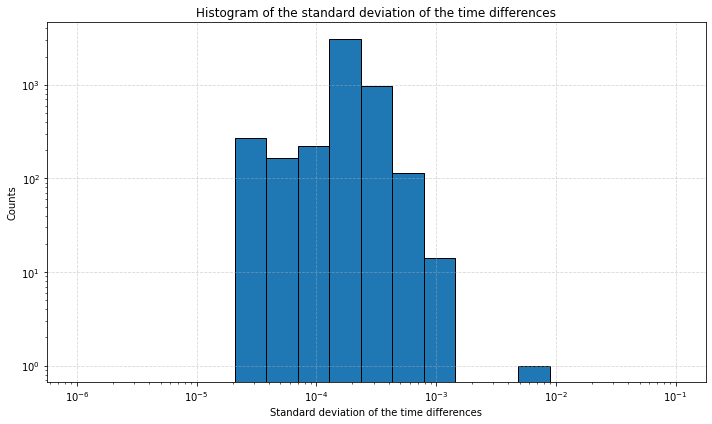

In [33]:
plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.5)
plt.hist(stds, bins=np.logspace(-6, -1, 20), edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Standard deviation of the time differences')
plt.ylabel('Counts')
plt.title('Histogram of the standard deviation of the time differences')
plt.tight_layout()
plt.show()